# Libs

In [1]:
# git clone https://github.com/sergsb/IUPAC2Struct.git
# pip install graphviz
# pip install torchview
# pip install torchinfo
# pip install torchviz
# !pip3 install pandas
# !pip3 install tqdm

In [2]:
import torch
import os
import numpy as np
import pylab
import pandas
import sys
from PIL import Image

/arc/project/st-dushan20-1/tensorflow-gpu/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    HOME_DIR = "/content"
else:
    HOME_DIR = "/arc/project/st-dushan20-1/rendered"

In [4]:
sys.path.append("/home/wg25r/with_pretrain/IUPAC2Struct")

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

if IN_COLAB:
    os.system('cp drive/MyDrive/WWVSB/iupac2smiles_model.pt .')

M = torch.load(f"iupac2smiles_model.pt", map_location=device)
M.device = device

/arc/project/st-dushan20-1/tensorflow-gpu/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/arc/project/st-dushan20-1/tensorflow-gpu/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'transformer.Transformer' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/arc/project/st-dushan20-1/tensorflow-gpu/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has c

In [6]:
M.tgt_model.encode("CC(=O)Nc1ccc(O)cc1")

[27, 27, 8, 23, 38, 9, 37, 54, 14, 54, 54, 54, 8, 38, 9, 54, 54, 14]

In [7]:
smiles_tokenlizer = M.tgt_model.encode

# Data Processing

In [8]:
# if IN_COLAB:
#   if not "80k" in "".join(os.listdir("/content")):
#     os.system("cp drive/MyDrive/80k.zip .")
#     os.system("cp drive/MyDrive/80k.csv .")
#     os.system("unzip 80k.zip")
#     HOME_DIR = "/content"
# else:
#   if not "80k" in "".join(os.listdir("/arc/project/st-dushan20-1/rendered")):
#     os.system("wget file.weasoft.com/80k.zip")
#     os.system("wget http://file.weasoft.com/80k.csv")
#     os.system("unzip 80k.zip")
#     HOME_DIR = "/arc/project/st-dushan20-1/rendered"


In [9]:
import os
ids = [i.split("_")[0] for i in os.listdir("/arc/project/st-dushan20-1/rendered/rendered")]

# with open("ids.txt", "w") as f:
#     f.write("\n".join(list(set(ids))))



In [10]:
import pandas as pd
csv = pd.read_csv("/home/wg25r/colab/80k.csv")
cids = csv["cid"]
csv.columns

Index(['cid', 'cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'isosmiles', 'canonicalsmiles', 'inchikey', 'iupacname', 'exactmass',
       'monoisotopicmass', 'charge', 'covalentunitcnt', 'isotopeatomcnt',
       'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
       'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt',
       'pclidcnt', 'gpidcnt', 'gpfamilycnt', 'neighbortype', 'meshheadings',
       'annothits', 'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [11]:
len(cids)

79368

In [12]:

Ys = {}
invalid_cids = []
for i in cids.values:
    tmp = smiles_tokenlizer(csv[csv["cid"] == i]["canonicalsmiles"].values[0])
    if not tmp == None:
      Ys[i] = tmp
    else:
      smiles_tokenlizer.append(i)

In [13]:
# if len(invalid_cids) == 0:
#   print("OOHH")

In [14]:
example_in = Image.open(f"{HOME_DIR}/rendered/6912034_0.jpg")
example_out = csv[csv["cid"]==6912034]["canonicalsmiles"].values[0]

In [15]:
example_out

'CC(=O)C'

In [16]:
M.tgt_model.decode(Ys[6912034])

'CC(=O)C'

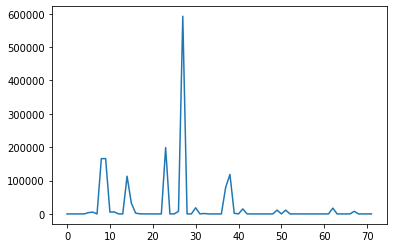

In [17]:
freq = [1] * 72
for i in Ys.keys():
  for j in Ys[i]:
    freq[j]+=1

reverse_freq = 1/np.array(freq)
pylab.plot(freq)

In [18]:
reverse_freq_ = reverse_freq**0.73
scales = np.mean(reverse_freq_)
np.mean(reverse_freq_/scales), np.min(reverse_freq_/scales)

(1.0, 9.272954661551446e-05)

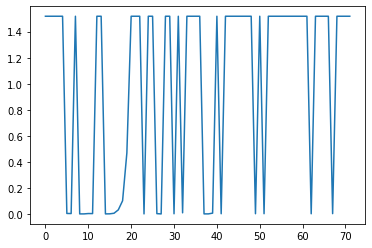

In [19]:
pylab.plot(reverse_freq_/scales)

In [20]:
weights = torch.tensor(reverse_freq_/scales).to(device)

# Model


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


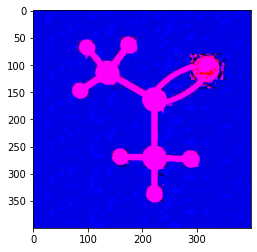

In [21]:
class ResNetBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, size, downsampling=True):
    super().__init__()
    self.Conv2D = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, (3,3), stride=2 if downsampling else 1, padding=(3 if size%2==0 else 2) if downsampling else 2),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_channels, out_channels, (3,3)),
        torch.nn.BatchNorm2d(out_channels),
    )
    self.project = torch.nn.Conv2d(in_channels, out_channels, (1,1))
    self.pooling = torch.nn.AvgPool2d((2,2)) if downsampling else torch.nn.Identity()
    self.relu = torch.nn.ReLU()
  def forward(self, images):
    x = self.Conv2D(images)
    images = self.pooling(self.project(images))
    return self.relu(x+images)
resblock = ResNetBlock(3,12,400, 0)
inp_img = torch.permute(torch.tensor(np.expand_dims(example_in, 0).astype("float32")), (0,3,1,2))
oup = resblock(inp_img)[:,-3:,:,:]
pylab.imshow(torch.permute(oup, (0,2,3,1)).cpu().detach().numpy()[0])

In [22]:
torch.permute(torch.tensor(np.expand_dims(example_in, 0).astype("float32")), (0,3,1,2)).size()

torch.Size([1, 3, 400, 400])

In [23]:
t = torch.randn(1,64,400,400)
torch.flatten(t)
torch.flatten(t, start_dim=2,end_dim=3).shape

torch.Size([1, 64, 160000])

In [24]:
def positional_encoding(pos, i):
  if i%2==0:
    return np.sin(pos/1000**(2*i/512))
  else:
    return np.cos(pos/1000**(2*i/512))


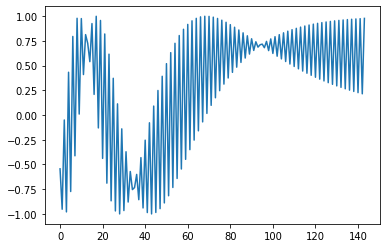

In [25]:
tmp = []
for i in range(144):
  tmp.append(positional_encoding(10, i))
pylab.plot(tmp)

In [26]:
class ImageEncoder(torch.nn.Module):
  def __init__(self, channels_list, heads, dropout, orginal_size):
    super().__init__()
    self.conv2d = torch.nn.Sequential(
        # torch.nn.Conv2d(3, 32, (7, 7), stride=3),
        # torch.nn.AvgPool2d((3,3), padding=1)
        torch.nn.Conv2d(3, 64, (7, 7), stride=2, padding=1),
        torch.nn.MaxPool2d((3, 3), stride=2)
    ).to(device)

    self.resnet_blocks = []
    for i in range(len(channels_list)-1):
      self.resnet_blocks.append(ResNetBlock(channels_list[i], channels_list[i], size=66//(2**i)).to(device))
      self.resnet_blocks.append(ResNetBlock(channels_list[i], channels_list[i+1], size=66//(2**i), downsampling=0).to(device)) #gangcai self not defined

    self.mlp = torch.nn.Sequential(
        torch.nn.Linear(512,800),
        torch.nn.GELU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(800, 512),
        torch.nn.GELU(),
    ).to(device)
    self.posem = torch.nn.Embedding(144, 512).to(device)
    self.mha = torch.nn.MultiheadAttention(channels_list[-1], heads, dropout = 0.1).to(device)
    self.norm = torch.nn.BatchNorm1d(144).to(device)

  def forward(self, images):
    features = self.conv2d(images)
    for f in self.resnet_blocks:
      features = f(features)
    features = torch.flatten(features, start_dim=2, end_dim=3)
    features = torch.permute(features, (0, 2, 1))
    ran = torch.arange(0, 144)
    pos = self.posem(ran.to(device).unsqueeze(0))
    features = pos + features
    att = self.mha(features, features, features, need_weights=False)[0]
    return self.norm(self.mlp(att) + features)



In [27]:
# posem = torch.nn.Embedding(36, 512)
# posem(torch.range(0, 36).unsqueeze(1))

In [28]:
NUM_HEADS = 8
CHANNELS = [64, 128, 256, 512]
DROPOUT = 0.2
inp_img = inp_img.to(device)
encoder = ImageEncoder(CHANNELS, NUM_HEADS, DROPOUT, 400)
encoder(inp_img).shape

torch.Size([1, 144, 512])

In [29]:
sum(p.numel() for p in encoder.parameters())

1954624

In [30]:
# from torchinfo import summary
# summary(encoder, (1,3,400,400), depth=10)

In [31]:
# from torchview import draw_graph

In [32]:
# import graphviz
# graphviz.set_jupyter_format('png')
# encoder.to(device)
# model_graph = draw_graph(encoder, input_size=(1, 3, 400, 400), depth=5, device=device)
# # model_graph.visual_graph

# Connect with pretrained


In [33]:
def subsequent_mask(tgt_mask):
    size = tgt_mask.size(-1)
    return tgt_mask.to(torch.uint8) & torch.tril(torch.ones(1,size,size, dtype=torch.uint8)).to(tgt_mask.device)

def pad_pack(sequences):
    maxlen = max(map(len, sequences))
    batch = torch.LongTensor(len(sequences),maxlen).fill_(0)
    for i,x in enumerate(sequences):
        batch[i,:len(x)] = torch.LongTensor(x)
    return batch

def find_first_working(x):
  for i in x:
    if i<=71:
      return i


In [34]:
inp = M.src_model.encode("N-(4-hydroxyphenyl)acetamide")
src = torch.tensor(pad_pack([inp]), device=(M.device))
src_mask = (src != 0).unsqueeze(-2).to(M.device)#.shape
latent = M.T.encoder(M.T.src_embedder(src), (src != 0).unsqueeze(-2).to(M.device))
l = latent.to(torch.device("cpu"))
l.cpu().detach().numpy()[0].shape

/arc/project/st-dushan20-1/tensorflow-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


(10, 512)

In [35]:
padded_tgt = pad_pack([[2]]).to(M.device)
empty_start = M.T.tgt_embedder(padded_tgt)

In [36]:
inp_img = inp_img.to(device)

In [37]:
inp_img.is_cuda

False

In [38]:
encoder = encoder.to(device)

In [39]:
encoder = encoder.to(device)

In [40]:
next(M.T.decoder.parameters()).is_cuda

False

In [41]:
latent = encoder(inp_img)
src_mask = (torch.zeros(len(latent[0]))).unsqueeze(-2).to(M.device)#.shape
out = M.T.decoder(empty_start, latent, src_mask, subsequent_mask((padded_tgt != 0).unsqueeze(-2)))

In [42]:
# Test for teaching forcing
# forcing = pad_pack([[2]+M.tgt_model.encode("CC(=O)Nc1ccc(O)cc")]).to(M.device)
forcing = pad_pack([[2,0]]).to(device)
forcing_start = M.T.tgt_embedder(forcing).to(device)

latent = encoder(inp_img)
src_mask = torch.ones(144).unsqueeze(-2).to(device)
out = M.T.decoder(forcing_start, latent, src_mask, subsequent_mask((forcing != 0).unsqueeze(-2)))
# out = M.T.decoder(forcing_start, l, src_mask, subsequent_mask((forcing != 0).unsqueeze(-2)))
out = M.T.generator(out)
print (out.shape)
ans = []
for i in range(2):
  ans.append(torch.sort(out[0], dim=1,
                        descending=True)[1].cpu().detach().numpy()[i][0])
M.tgt_model.decode(ans)

torch.Size([1, 2, 72])


'C#'

In [43]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

for i in M.T.decoder.parameters():
  i.requires_grad = False

for i in M.T.generator.parameters():
  i.requires_grad = False

In [44]:
sum(p.numel() for p in M.T.decoder.parameters() if p.requires_grad)

0

In [45]:
class Image2SMILES(torch.nn.Module):
  def __init__(self, encoder, embeding, decoder, generator):
    super().__init__()
    self.encoder = encoder
    self.embeding = embeding
    self.decoder = decoder
    self.generator = generator

  def forward (self, image, text_in):
    image_feature = self.encoder(image)
    paded = pad_pack(text_in).to(device)
    embedded = self.embeding(paded)
    out = self.decoder(embedded, image_feature,
                       torch.ones(144).unsqueeze(-2).to(M.device), #ones?
                       subsequent_mask((paded != 0)
                       .unsqueeze(-2)))
    out = self.generator(out)
    return out

In [46]:
class SMILESGenerator(torch.nn.Module):
  def __init__(self, encoder, embeding, decoder, generator, max_len):
    super().__init__()
    self.encoder = encoder
    self.embeding = embeding
    self.decoder = decoder
    self.generator = generator
    self.max_len = max_len

  def forward (self, image, text_in):
    image_feature = self.encoder(image)
    for i in range(self.max_len):
      paded = pad_pack(text_in).to(device)
      embedded = self.embeding(paded)
      out = self.decoder(embedded, image_feature,
                        torch.ones(144).unsqueeze(-2).to(M.device),
                        subsequent_mask((paded != 0)
                        .unsqueeze(-2)))
      out = self.generator(out)
      next = torch.sort(out, descending=True)[1][0,0].cpu().detach().numpy()[0] #forgot descending
      if next == 3:
        break
      text_in[0] += [next]
      # print(text_in)
    return M.tgt_model.decode(text_in[0])


In [47]:
model = Image2SMILES(encoder.to(device),
    M.T.tgt_embedder.to(device),
             M.T.decoder.to(device), M.T.generator.to(device))

In [48]:
gen = SMILESGenerator(encoder,
    M.T.tgt_embedder,
             M.T.decoder, M.T.generator, 10)

In [49]:
torch.argmax(model(inp_img, [[2, 0]])[0,0])

tensor(11)

In [50]:
gen(inp_img, [[2]])

'C][@]@N/@n'

In [51]:
def softmax(x):
  t = np.exp(x)
  return t/np.sum(t)

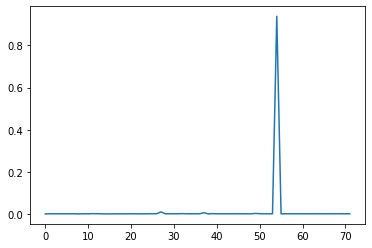

In [52]:
pylab.plot(softmax(model(inp_img, [[2, 0]])[0][0].cpu().detach().numpy()))

In [53]:
M.tgt_model.decode([37])

'N'

In [54]:
sum(p.numel() for p in model. parameters() if not p.requires_grad)

25262152

# Training


In [55]:
import torch
# torch.gather(
#     torch.tensor([0.,0.2,0.3,0.4,0.5]), 0, torch.tensor([[1,2,3]], dtype=torch.int64), 
# # )
# w = torch.tensor([0.,0.2,0.3,0.4,0.5])
# ind = torch.tensor([[1,2,3],[0,1,2
# ]])
# w[ind]

In [56]:
lf = torch.nn.CrossEntropyLoss(label_smoothing=0.1, reduction="none")
def loss_fn(pred, truth):
  # jiaosuan xkou shuijiaoshi turanxiangdao wangjile weight
  w = weights[truth]
  mask = truth != 0
  pred = pred.permute(0,2,1) #WHY
  truth = torch.nn.functional.one_hot(truth, num_classes=72).type(torch.float32).permute(0,2,1)
  l = lf(pred, truth) * w
  return torch.sum(mask*l)/torch.sum(mask)

In [57]:
def saveloss(loss_list):
  pylab.scatter(np.arange(len(loss_list)), loss_list)
  pylab.plot(np.arange(len(loss_list)), loss_list)
  pylab.savefig("loss.jpg")
  with open("loss.txt","a") as f:
    f.write("\n".join([str(i) for i in loss_list]))

In [58]:
sum(p.numel() for p in model.parameters() if not p.requires_grad)

25262152

In [59]:
import pickle
with open("Ys.pkl","wb") as f:
  pickle.dump(Ys, f)
os.system("cp Ys.pkl drive/MyDrive/")

256

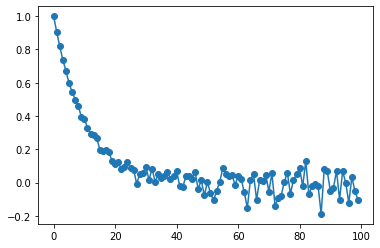

In [60]:
_ = list(map(lambda x: np.exp(-0.1*x)+np.random.normal()*0.001*x, list(range(100))))
saveloss(_)

In [61]:

BATCH_SIZE = 32
files = os.listdir(f"{HOME_DIR}/rendered/")
import multiprocessing, threading
import queue
import time
# data_reader, trainer = multiprocessing.Pipe()
buffer = queue.Queue(maxsize=10) #need maxsize=10, otherwise put will also block
start_index = 0

def process_single(arg):
    _, start_index = arg
    index = start_index + _
    try:
      id = int(files[index].split("_")[0])
    except:
      return
    index = start_index + _
    img = np.array(Image.open(f"{HOME_DIR}/rendered/{files[index]}"), dtype="float32")
    # img = np.array(Image.open(f"rendered/{files[index]}").rotate(np.random.uniform(0,360), expand = 1).resize((400,400)), dtype="float32")
    # noise = np.random.uniform(size=img.shape)*20
    # img += noise
    return img, [2] + Ys[id], Ys[id] + [3]
    # Xs_img.append(img)
    # Xs_text.append([2] + Ys[id])
    # y.append(Ys[id] + [3])

def getitem(index):
  start_index = index * BATCH_SIZE
  Xs_img = []
  Xs_text = []
  y = [] #This is slow, rewrite later

  pool = multiprocessing.Pool()
  ans = pool.map(process_single, zip(range(BATCH_SIZE), [start_index]*BATCH_SIZE))
  pool.close()

  Xs_img = [i[0] for i in ans]
  Xs_text = [i[1] for i in ans]
  y = [i[2] for i in ans]
  Xs_img = torch.permute(torch.tensor(np.array(Xs_img)), (0,3,1,2))
  buffer.put(([Xs_img, pad_pack(Xs_text)], pad_pack(y)))

p = threading.Thread(target=getitem, args=(0,)) #It says threading no process, did i used the wrong li
p.start()
print("Started")
# buffer.get()

Started


In [62]:
t = [[1,'a','b'],
     [1,'a','b'],
     [1,'a','b']]
col_1 = [i[0] for i in t] #gpt
col_1

[1, 1, 1]

In [63]:
next(zip([1,2,3],[0,0,0]))

(1, 0)

In [64]:
# https://superfastpython.com/multiprocessing-pool-for-loop/
# naoziyunle def douwnagjiel
def task(x):
  return x+1 if x%3!=0 else None

pool = multiprocessing.Pool()
ans = pool.map(task, range(10))
pool.close()
list(filter(lambda x: not x is None, ans))

[2, 3, 5, 6, 8, 9]

In [65]:
p = threading.Thread(target=getitem, args=(0,)) #FUCK I KNOW because here is proess touyunchaojieks
# p = multiprocessing.Process(target=getitem, args=(0,)) #FUCK I KNOW because here is proess touyunchaojieks
p.start()
p.join()
buffer.empty()

False

In [69]:
# https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5)


loss_list = []
model.to(device)

#empty queue
while not buffer.empty():
  buffer.get()

p = threading.Thread(target=getitem, args=(0,))
p.start()
p.join()

for epoch in range(30):
  np.random.shuffle(files)
  print('EPOCH {}:'.format(epoch + 1))
  model.train(True)
  # running_loss = 0.
  last_loss = 0.
  for i in range(len(files)//BATCH_SIZE):
    if i != len(files)//BATCH_SIZE - 1:
      p = threading.Thread(target=getitem, args=(i+1,))
      p.start()

    loaded = not buffer.empty()
    if not loaded:
      print("WARNING: reading too slow")
      pass

    (image, text_in), text_out = buffer.get(block=True)
    # if not loaded:
    #   print("Loaded")

    image = image.to(device)
    text_out = text_out.to(device)
    optimizer.zero_grad()
    outputs = model(image, text_in)
    loss = loss_fn(outputs, text_out)
    loss.backward()

    optimizer.step()

    # running_loss += loss.item()
    # if i%3 == 2:
    print(f"Training loss: {loss.item()}") #first time loss is small because it is dived by 10 where there is only 1
    loss_list.append(loss.item())
    saveloss(loss_list)

    if i%20 == 0:
      print(f"Example Output: {gen(inp_img, [[2]])}")
    if i%30 == 29:
      scheduler.step()
      print(f"New learning rate: {optimizer.param_groups[0]['lr']}")